# Análise exploratória completa para um estado do Brasil

Neste *notebook* vou usar os dados de seguro rural de 2021, selecionar as apólices de apenas um estado do Brasil e realizar todas as análises feitas:

- visão geral dos dados (*shape*, *head*, *tail*, *sample*, *dtypes*)
- resumo estatístico: *describe*
- gráficos para variáveis quantitativas: histogramas, *boxplots*
- gráficos para variáveis qualitativas: gráficos de colunas, de barras, linhas, pizza
- diagramas de dispersão
- mapas de calor (*heatmaps*)
- agrupamento dos dados: *groupby*


Importar pacotes necessários:

In [5]:
import pandas as pd
import numpy as np
from google.colab import drive, files
import os
pd.set_option('display.max_columns', 50)             # permite a visualização de 50 colunas do dataframe
pd.options.display.float_format = '{:.2f}'.format    # pandas: para todos os números aparecerem com duas casas decimais

# parte gráfica
import matplotlib.pyplot as plt
import seaborn as sns

# Criação dos dados - ATENÇÃO!

NÃO É necessário executar os códigos da célula abaixo se os dados de 2021 (ou outro ano) já estão salvos. Pule para a leitura dos dados.

A célula abaixo realiza todos os passos necessários para carregar os dados de seguro rural de 2016 a 2021, limpar, organizar, separar os dados de 2021 e salvar a planilha.

Tarefa feita no notebook de limpeza e organização: https://colab.research.google.com/drive/1YG5gjUd_U4DTcCLT1nWnvxXCBRylLn0G?authuser=1

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/content/drive/My Drive/')
# tire o comentário se quiser executar
# dados = pd.read_excel("psrdadosabertos2016a2021excel.xlsx", decimal=',')

# seleção de dados
dados21 = dados[dados['ANO_APOLICE'] == 2021]
seg = dados21.copy()
seg = seg.reset_index(drop=True)
# limpeza e organização
seg = seg.fillna(0)
df = seg.replace(['-', '...', 'X'], 0)
df.dropna(inplace=True, how='all')
df.dropna(inplace=True)
# criação de nova coluna
df['DT_FIM_VIGENCIA'] = pd.to_datetime(df['DT_FIM_VIGENCIA'], errors = 'coerce')
df['duracao'] = (df['DT_FIM_VIGENCIA'] - df['DT_INICIO_VIGENCIA']).dt.days
df.dropna(inplace=True)
# apagar colunas sem interesse
retirar = ['CD_PROCESSO_SUSEP', 'NR_PROPOSTA', 'ID_PROPOSTA',
       'DT_PROPOSTA', 'DT_INICIO_VIGENCIA', 'DT_FIM_VIGENCIA', 'NM_SEGURADO',
       'NR_DOCUMENTO_SEGURADO','LATITUDE', 'NR_GRAU_LAT', 'NR_MIN_LAT',
       'NR_SEG_LAT', 'LONGITUDE', 'NR_GRAU_LONG', 'NR_MIN_LONG', 'NR_SEG_LONG',
       'NR_DECIMAL_LATITUDE', 'NR_DECIMAL_LONGITUDE', 'DT_APOLICE', 'ANO_APOLICE']
df = df.drop(retirar, axis=1)
# corrigir strings
df['EVENTO_PREPONDERANTE'] = df['EVENTO_PREPONDERANTE'].str.split().str.join(' ')
df['EVENTO_PREPONDERANTE'] = df['EVENTO_PREPONDERANTE'].replace([np.NaN], '0')
df['NM_RAZAO_SOCIAL'] = df['NM_RAZAO_SOCIAL'].str.strip()
df['NM_CULTURA_GLOBAL'] = df['NM_CULTURA_GLOBAL'].str.strip()
# mudar nomes de colunas
df.columns = ['seguradora', 'nome_mun', 'uf',
              'tipo', 'cultura', 'area', 'animal',
              'prod_est', 'prod_seg', 'nivel_cob',
              'total_seg', 'premio', 'taxa',
              'subvencao', 'apolice', 'mun', 'indenizacao',
              'evento', 'duracao']
df['mun'] = df['mun'].astype(int)
# criar outras colunas
df['sinistralidade'] = df['indenizacao'] / df['premio']
df['sinistro'] = np.where(df['evento'].str.isnumeric(), 0, 1)
# organizar colunas
df = df.loc[:, ['apolice', 'mun', 'nome_mun', 'uf', 'seguradora', 'tipo',
                'cultura', 'area', 'animal', 'duracao',
                'prod_est', 'prod_seg', 'nivel_cob', 'total_seg',
                'premio', 'taxa', 'subvencao', 'indenizacao',
                'evento', 'sinistro', 'sinistralidade']]

# salvar novos dados
# tire o comentário se quiser salvar
# df.to_excel("seguro-rural-2021.xlsx", index=False)

# Leitura dos dados

Lendo a partir do *google drive*.

In [6]:
# demora um pouco
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/dados')
seg = pd.read_excel("seguro-rural-2021.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# fazer uma cópia do dataframe seg
# assim, não o alteramos diretamente
df_br = seg.copy()

In [8]:
# número de linhas (apólices) e colunas (variáveis)
df_br.shape

(212838, 21)

In [9]:
# modificar as ocorrências das variáveis 'tipo', 'evento'
# agrupar as culturas em 'tipo_cultura'

# simplificar os tipos de seguro da variável 'tipo'
df_br['tipo'].replace({'CUSTEIO': 'custeio',
                    'PRODUTIVIDADE': 'produtividade',
                    'FLORESTAS': 'florestas',
                    'RECEITA': 'receita',
                    'PECUÁRIO': 'pecuário'}, inplace=True)

# simplificar os nomes de eventos preponderantes da variável 'evento'
df_br['evento'].replace({'0':'nenhum',
                      'SECA': 'seca',
                      'GEADA': 'geada',
                      'CHUVA EXCESSIVA': 'chuva',
                      'GRANIZO': 'granizo',
                      'VENTOS FORTES/FRIOS': 'vento',
                      'INUNDAÇÃO/TROMBA D´ÁGUA': 'inundação',
                      'VARIAÇÃO EXCESSIVA DE TEMPERATURA': 'temp.',
                      'INCÊNDIO': 'incêndio',
                      'DEMAIS CAUSAS': 'outras',
                      'VARIAÇÃO DE PREÇO': 'var. preço',
                      'REPLANTIO': 'replantio',
                      'RAIO': 'raio',
                      'MORTE': 'morte',
                      'QUEDA DE PARREIRAL': 'queda parr.',
                      'PERDA DE QUALIDADE': 'perda qual.'}, inplace=True)

# criar variável 'tipo_cultura' para agrupar as culturas em
# categorias: 'grãos', 'perenes', 'leguminosas', 'sementes',
# 'hortaliças', 'frutas', 'outros'
df_br['tipo_cultura'] = df_br['cultura'].replace({'Soja': 'grãos',
                                            'Milho 1ª safra': 'grãos',
                                            'Milho 2ª safra': 'grãos',
                                            'Cana-de-açúcar': 'perenes',
                                            'Trigo': 'grãos',
                                            'Feijão 1ª safra': 'leguminosas',
                                            'Sorgo': 'grãos',
                                            'Café': 'perenes',
                                            'Cevada': 'sementes',
                                            'Batata': 'hortaliças',
                                            'Arroz': 'grãos',
                                            'Aveia': 'grãos',
                                            'Canola': 'grãos',
                                            'Centeio': 'grãos',
                                            'Algodão': 'grãos',
                                            'Mandioca': 'hortaliças',
                                            'Feijão 2ª safra': 'leguminosas',
                                            'Amendoim': 'leguminosas',
                                            'Triticale': 'grãos',
                                            'Pecuário': 'perenes',
                                            'Cebola': 'hortaliças',
                                            'Alho': 'hortaliças',
                                            'Melancia': 'frutas',
                                            'Tomate': 'hortaliças',
                                            'Girassol': 'grãos',
                                            'Abóbora': 'hortaliças',
                                            'Atemoia': 'frutas',
                                            'Cenoura': 'hortaliças',
                                            'Couve-flor': 'hortaliças',
                                            'Goiaba': 'frutas',
                                            'Laranja': 'frutas',
                                            'Tangerina': 'frutas',
                                            'Melão': 'frutas',
                                            'Pepino': 'hortaliças',
                                            'Pimentão': 'hortaliças',
                                            'Repolho': 'hortaliças',
                                            'Uva': 'frutas',
                                            'Beterraba': 'hortaliças',
                                            'Ameixa': 'frutas',
                                            'Chuchu': 'hortaliças',
                                            'Kiwi': 'frutas',
                                            'Maracujá': 'frutas',
                                            'Nectarina': 'frutas',
                                            'Pêssego': 'frutas',
                                            'Brócolis': 'hortaliças',
                                            'Pêra': 'frutas',
                                            'Pastagem': 'outros',
                                            'Caqui': 'frutas',
                                            'Maçã': 'frutas',
                                            'Floresta': 'outros',
                                            'Banana': 'frutas',
                                            'Abacate': 'frutas',
                                            'Abobrinha': 'hortaliças',
                                            'Alface': 'hortaliças',
                                            'Vagem': 'hortaliças',
                                            'Cacau': 'frutas',
                                            'Berinjela': 'hortaliças',
                                            'Figo': 'frutas',
                                            'Manga': 'frutas',
                                            'Ervilha': 'leguminosas',
                                            'Mamão': 'frutas',
                                            'Morango': 'frutas',
                                            'Lichia': 'frutas',
                                            'Abacaxi': 'frutas',
                                            'Limão': 'frutas'})

<ipython-input-9-c8f62018d8c1>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_br['tipo'].replace({'CUSTEIO': 'custeio',
<ipython-input-9-c8f62018d8c1>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [10]:
# reorganizar as colunas
df_br = df_br.loc[:, ['apolice', 'mun', 'nome_mun', 'uf', 'seguradora', 'tipo',
                'cultura', 'tipo_cultura', 'area', 'animal', 'duracao',
                'prod_est', 'prod_seg', 'nivel_cob', 'total_seg', 'premio',
                'taxa', 'subvencao', 'indenizacao', 'evento', 'sinistro',
                'sinistralidade']]

In [11]:
# uma pequena amostra dos dados para visualização
df_br.sample(5)

,apolice,mun,nome_mun,uf,seguradora,tipo,cultura,tipo_cultura,area,animal,duracao,prod_est,prod_seg,nivel_cob,total_seg,premio,taxa,subvencao,indenizacao,evento,sinistro,sinistralidade
116504,1000111162253,3509304,Cajobi,SP,Essor Seguros S.A.,produtividade,Soja,grãos,76.00,0,309,3092.31,2010.00,0.65,358986.00,22687.93,0.06,4537.59,0.00,nenhum,0,0.00
78581,1000111151848,4313359,Nova Roma do Sul,RS,Essor Seguros S.A.,produtividade,Uva,frutas,1.22,0,333,27596.00,27596.00,1.00,34000.10,2040.00,0.06,816.00,0.00,granizo,1,0.00
98209,144920,4104303,Campo Mourão,PR,BRASILSEG COMPANHIA DE SEGUROS,custeio,Soja,grãos,89.54,0,365,3652.00,2739.00,0.75,279186.63,19142.49,0.07,3828.50,60241.32,seca,1,3.15
1441,491321,4108304,Foz do Iguaçu,PR,BRASILSEG COMPANHIA DE SEGUROS,custeio,Milho 2ª safra,grãos,96.80,0,365,6000.00,3900.00,0.65,194674.48,19418.77,0.10,7767.51,0.00,nenhum,0,0.00
63909,3355002483101,4302105,Bento Gonçalves,RS,Mapfre Seguros Gerais S.A.,custeio,Uva,frutas,0.91,0,339,40000.00,40000.00,1.00,30011.80,1853.72,0.06,741.49,518.62,granizo,1,0.28


In [12]:
# verificar se há dados faltantes
df_br.isna().sum()

,0
apolice,0
mun,0
nome_mun,0
uf,0
seguradora,0
tipo,0
cultura,0
tipo_cultura,0
area,0
animal,0


# Seleção de apólices de um estado do Brasil

In [13]:
# visualizar os valores únicos da variável 'uf'
df_br['uf'].unique()

array(['GO', 'MT', 'PR', 'MS', 'MG', 'SP', 'ES', 'TO', 'SC', 'DF', 'BA',
       'RS', 'MA', 'PI', 'PB', 'PA', 'RO', 'SE', 'CE', 'PE', 'AM', 'RJ',
       'AL', 'RR', 'RN', 'AC'], dtype=object)

In [14]:
# escolher um dos estados e selecionar apólices apenas desse estado
# aqui estou apenas visualizando sem salvar
# df_br[df_br['uf'] == 'MG']

In [15]:
# salvar essas informações num dataframe
df = df_br[df_br['uf'] == 'MG']
df = df.reset_index(drop=True) # iniciar os índices em 0
df.head(5)

,apolice,mun,nome_mun,uf,seguradora,tipo,cultura,tipo_cultura,area,animal,duracao,prod_est,prod_seg,nivel_cob,total_seg,premio,taxa,subvencao,indenizacao,evento,sinistro,sinistralidade
0,10001010026812,3127107,Frutal,MG,Newe Seguros S.A,custeio,Milho 2ª safra,grãos,150.00,0,181,5485.80,3840.00,0.70,480000.00,38880.00,0.08,15552.00,195364.01,seca,1,5.02
1,10001010026801,3127107,Frutal,MG,Newe Seguros S.A,custeio,Milho 2ª safra,grãos,80.00,0,181,5485.80,3840.00,0.70,256000.00,20736.00,0.08,8294.40,105278.14,seca,1,5.08
2,1000111087656,3126208,Formoso,MG,Sancor Seguros do Brasil S.A.,produtividade,Milho 2ª safra,grãos,19.00,0,210,4705.80,3058.77,0.65,40681.64,6018.01,0.15,2407.20,14377.73,seca,1,2.39
3,1101.64.42532,3171709,Virgínia,MG,Porto Seguro Companhia de Seguros Gerais,produtividade,Tomate,hortaliças,0.29,0,365,75000.00,67500.00,0.90,21900.00,2842.00,0.13,1136.80,0.00,nenhum,0,0.00
4,10001010026926,3100708,Água Comprida,MG,Newe Seguros S.A,custeio,Milho 2ª safra,grãos,115.00,0,180,5142.00,3600.00,0.70,310500.00,23598.00,0.08,9439.20,0.00,seca,1,0.00


In [16]:
# quantas linhas e colunas há no novo dataframe
df.shape

(16605, 22)

# Análise descritiva

In [17]:
# quantas apólices há de cada município
df['nome_mun'].value_counts().head(10)

,count
nome_mun,
Paraguaçu,658
Virgínia,530
Mutum,387
Campos Gerais,347
Patrocínio,341
Boa Esperança,328
Lajinha,308
Santana de Pirapama,307
Durandé,257


In [18]:
# há informações sobre quantos municípios no estado?
len(df['nome_mun'].unique())

632

In [19]:
# resumo estatístico das variáveis numéricas
df.loc[:, ['area', 'animal', 'duracao', 'prod_est', 'prod_seg',
       'nivel_cob', 'total_seg', 'premio', 'taxa', 'subvencao', 'indenizacao',
       'evento', 'sinistro', 'sinistralidade']].describe()

,area,animal,duracao,prod_est,prod_seg,nivel_cob,total_seg,premio,taxa,subvencao,indenizacao,sinistro,sinistralidade
count,16605.00,16605.00,16605.00,16605.00,16605.00,16605.00,16605.00,16605.00,16605.00,16605.00,16605.00,16605.00,16605.00
mean,64.65,0.78,344.68,5818.35,4692.29,0.44,358657.31,12855.68,0.04,3942.99,10601.74,0.16,0.81
std,2264.05,12.60,52.28,18010.93,15601.58,0.35,972114.41,18932.07,0.03,5439.63,67400.60,0.37,3.22
min,0.00,0.00,30.00,0.00,0.00,0.00,1513.40,55.34,0.00,9.15,0.00,0.00,0.00
25%,4.00,0.00,365.00,0.00,0.00,0.00,63795.31,2091.00,0.02,749.68,0.00,0.00,0.00
50%,14.40,0.00,365.00,2444.00,1625.00,0.65,170418.00,6288.05,0.04,2055.15,0.00,0.00,0.00
75%,50.00,0.00,365.00,3575.00,2600.00,0.70,399999.90,15624.68,0.05,4820.20,0.00,0.00,0.00
max,290985.00,787.00,730.00,256410.26,230769.23,1.00,89593798.95,285548.96,1.00,48000.00,2320065.28,1.00,55.48


O *describe* traz um resumo estatístico dos dados. Para os dados de MG em 2021:

**1 - Interpretação do resumo estatístico:**

Vamos analisar a variável 'premio', por exemplo:
- o valor mínimo de prêmio em MG foi 55,34 reais, ou seja, um apólice apresentou esse valor de prêmio
- o valor máximo foi 285.548,96 reais, ou seja, o maior prêmio de uma apólice em MG em 2021
- o primeiro quartil, Q1, foi 2.097,99 reais, ou seja, um quarto das apólices de MG tinham valores de prêmio abaixo disso
- a mediana, o segundo quartil, Q2, foi 6.294,83 reais, ou seja, metade das apólices de MG tinham valores de prêmio abaixo disso e metade tinham valores acima dele
- o terceiro quartil, Q3, foi 15.646,11 reais, ou seja, um quarto das apólices de MG tinham valores de prêmio acima desse valor
- a média de prêmio foi 12.890,28 reais, sendo que a mediana foi 6.294,83 reais. Isso significa que há valores muito altos de prêmio que puxaram o valor da média para cima.

Para as outras variáveis, as análises são as mesmas. Não é comum fazer uma análise tão detalhada assim de todas as variáveis, mas chamar a atenção para pontos importantes e que sejam de interesse para a pesquisa.

Por exemplo, o valor de subvenção varia de 9,15 reais a 48.000,00. Uma amplitude muito alta.

É possível identificar pontos de interesse nos dados. Veja abaixo:

In [20]:
# menor valor de prêmio
df[df['premio'] == df['premio'].min()]

,apolice,mun,nome_mun,uf,seguradora,tipo,cultura,tipo_cultura,area,animal,duracao,prod_est,prod_seg,nivel_cob,total_seg,premio,taxa,subvencao,indenizacao,evento,sinistro,sinistralidade
10331,1000100057010,3149101,Pedralva,MG,FairFax Brasil Seguros Corporativos S/A,produtividade,Café,perenes,0.60,0,303,0.00,0.00,0.00,8100.00,55.34,0.01,22.14,0.00,nenhum,0,0.00


In [21]:
# maior valor de prêmio
df[df['premio'] == df['premio'].max()]

,apolice,mun,nome_mun,uf,seguradora,tipo,cultura,tipo_cultura,area,animal,duracao,prod_est,prod_seg,nivel_cob,total_seg,premio,taxa,subvencao,indenizacao,evento,sinistro,sinistralidade
14956,190939,3128600,Guarda-Mor,MG,BRASILSEG COMPANHIA DE SEGUROS,custeio,Feijão 1ª safra,leguminosas,500.00,0,365,2520.00,1764.00,0.70,3283813.02,285548.96,0.09,8089.53,0.00,nenhum,0,0.00


In [22]:
# um valor específico de indenização
df[df['indenizacao'] == 1597620.80]

,apolice,mun,nome_mun,uf,seguradora,tipo,cultura,tipo_cultura,area,animal,duracao,prod_est,prod_seg,nivel_cob,total_seg,premio,taxa,subvencao,indenizacao,evento,sinistro,sinistralidade
2258,02010106079,3104304,Areado,MG,Swiss Re Corporate Solutions Brasil S.A.,produtividade,Café,perenes,85.82,0,365,0.00,0.00,0.00,2027055.69,64385.66,0.03,25754.25,1597620.80,geada,1,24.81


## Gráficos

In [23]:
# as dez culturas com mais apólices de seguro no estado em 2021
df['cultura'].value_counts().head(10)

,count
cultura,
Café,8512
Soja,3120
Tomate,1100
Milho 1ª safra,966
Pecuário,840
Milho 2ª safra,820
Cana-de-açúcar,342
Sorgo,260
Ameixa,172


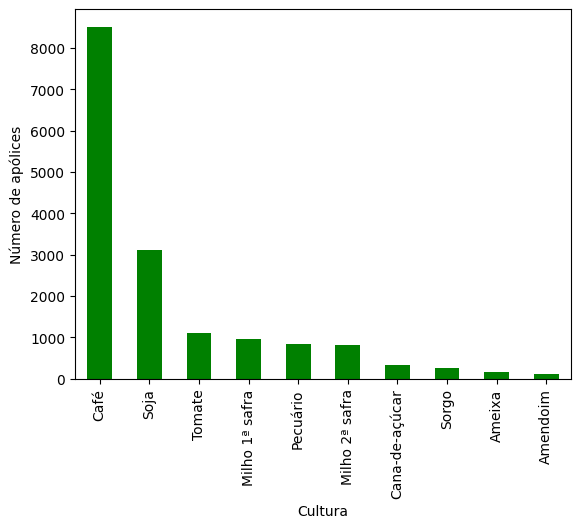

In [24]:
# gráfico de colunas - 10 culturas com mais apólices no estado
ax = df['cultura'].value_counts() \
    .head(10) \
    .plot(kind='bar', title='', color='green')
ax.set_xlabel('Cultura')
ax.set_ylabel('Número de apólices');

**2 - Interpretação do gráfico de colunas com as dez culturas mais seguradas:**

As dez principais culturas seguradas de MG em 2021 foram, nessa ordem:
- café (com mais de 8 mil apólices)
- soja (com pouco mais de 3 mil apólices)
- tomate (com pouco mais de mil apólices)
- milho 1. safra
- pecuário
- milho 2. safra
- cana
- sorgo
- ameixa
- amendoim

Café, soja e tomate concentram as apólices de seguro do estado. As outras não chegam a mil apólices.

Realizar a soma das variáveis de forma separada por cultura para o estado todo:

In [25]:
# total para todas as culturas
df_todas = df.groupby(by=['cultura']).sum(numeric_only=True)
# mostrar apenas as variáveis de interesse
df_todas.loc[:, ['area', 'animal', 'prod_est', 'prod_seg',
       'total_seg', 'premio', 'subvencao', 'indenizacao', 'sinistro']]

,area,animal,prod_est,prod_seg,total_seg,premio,subvencao,indenizacao,sinistro
cultura,,,,,,,,,
Abacate,52.73,0,57000.00,57000.00,726769.50,60802.80,24321.11,139188.52,1
Abacaxi,1201.50,0,0.00,0.00,1022500.00,40900.00,16360.00,0.00,0
Abobrinha,1.65,0,0.00,0.00,15622.50,1160.24,464.09,0.00,1
Abóbora,13.86,0,0.00,0.00,288903.50,15835.00,6334.00,48954.73,9
Algodão,276.97,0,5890.00,4524.50,3789488.55,224801.86,47604.40,0.00,0
Alho,739.32,0,479000.00,479000.00,47774066.40,964243.85,371355.96,0.00,1
Ameixa,421.99,0,2342741.46,2241117.80,7568161.97,1128947.84,449611.14,2266894.08,98
Amendoim,10958.28,0,767138.23,537349.75,102084254.32,5520806.86,1369806.20,9068691.67,56
Arroz,138.00,0,21450.00,15015.00,562450.52,22498.02,5624.51,0.00,0


In [26]:
# realizar a soma apenas para as 10 culturas com mais apólices do estado

# descobrindo as 10 culturas com mais apólices
df_cult = pd.DataFrame(df['cultura'].value_counts().head(10)).reset_index()
df_cult.columns = ['cultura', 'apolices']
# pegar as linhas no df que correspondam a apólices dessas culturas
df1 = df.merge(df_cult, how='inner')
# realizar a soma das variáveis apenas para essas culturas
df2 = df1.groupby(by=['cultura']).sum(numeric_only=True)
# mostrar apenas as variáveis de interesse
df2.loc[:, ['area', 'animal', 'prod_est', 'prod_seg',
       'total_seg', 'premio', 'subvencao', 'indenizacao', 'sinistro']]

,area,animal,prod_est,prod_seg,total_seg,premio,subvencao,indenizacao,sinistro
cultura,,,,,,,,,
Ameixa,421.99,0,2342741.46,2241117.80,7568161.97,1128947.84,449611.14,2266894.08,98
Amendoim,10958.28,0,767138.23,537349.75,102084254.32,5520806.86,1369806.20,9068691.67,56
Café,212743.14,0,9806753.90,6452792.17,2757081802.69,68289782.79,27082014.96,117719249.74,1278
Cana-de-açúcar,40071.69,0,4178606.60,2890253.54,253822862.62,4190819.95,1662791.56,1582033.25,31
Milho 1ª safra,51368.22,0,6570158.09,4884191.97,271577349.76,14897772.76,3726056.01,1124773.69,68
Milho 2ª safra,84341.69,0,4879782.45,3209615.35,281665882.18,19799108.50,7390819.50,15996272.48,288
Pecuário,0.00,12886,0.00,0.00,363508067.10,5342560.56,2051479.51,1008122.75,19
Soja,623285.42,0,10699691.79,7741918.94,1578158144.75,75439427.14,14640898.70,7282550.05,170
Sorgo,29443.91,0,1007555.28,658061.25,59010243.90,3636443.68,1435070.13,4975019.05,65


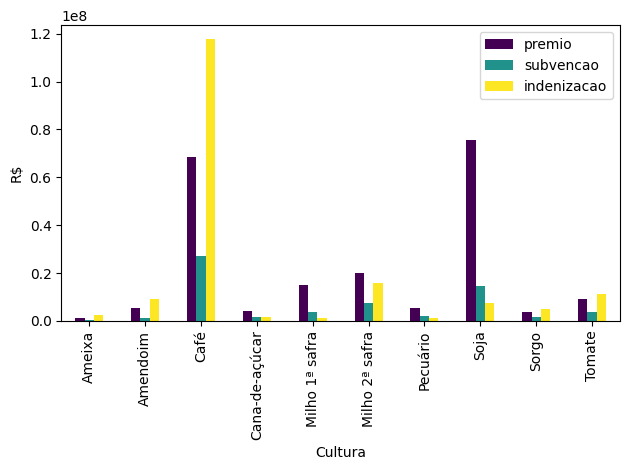

In [27]:
# fazer um gráfico com os valores de prêmio, subvenção
# e indenização para as 10 culturas mais seguradas
# outras variáveis poderiam ser incluídas no gráfico
df2[['premio','subvencao','indenizacao']].plot.bar(colormap=plt.cm.viridis)
plt.xlabel('Cultura')
plt.ylabel('R$')
plt.tight_layout();

**3 - Interpretação do gráfico comparativo das somas dos valores de prêmio, subvenção e indenização das dez culturas mais seguradas:**

É possível ver que, para as culturas de café, milho 2. safra, sorgo, ameixa e tomate, o valor total das indenizações superou o valor total dos prêmios. Isso é ruim para as seguradoras, que podem vir a ter prejuízos. Porém, com a soja, que foi uma cultura muito segurada em 2021, o valor dos prêmios é muito maior do que as indenizações, o que pode ajudar a diminuir esse prejuízo. Isso tudo levando em conta as 10 culturas mais seguradas do estado.

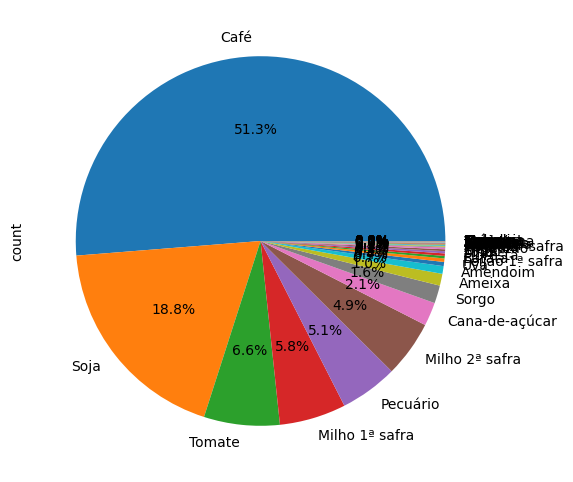

In [28]:
# gráfico de pizza - todas as culturas no estado
plt.figure(figsize=(10,6))
df['cultura'].value_counts().plot(kind='pie', autopct='%1.1f%%');

**4 - Interpretação do gráfico de pizza com a porcentagem das apólices de cada cultura:**

O café representa mais de metade das apólices do estado de MG e a soja representa 19%. As outras possuem uma representatividade menor, sendo elas: tomate com 6,6%, milho 1.safra com 6%, pecuário com 5% e as outras representam menos de 5% das apólices.

In [29]:
# número de apólices por tipo de cultura
df['tipo_cultura'].value_counts()

,count
tipo_cultura,
perenes,9694
grãos,5201
hortaliças,1221
frutas,279
leguminosas,174
outros,36


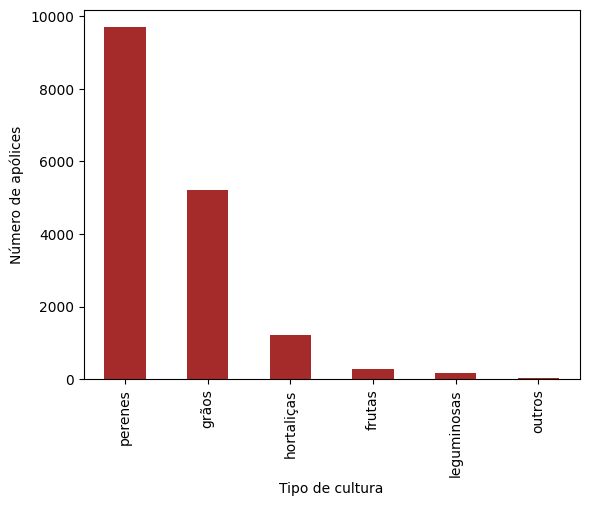

In [30]:
# gráfico de colunas - tipos de cultura
ax = df['tipo_cultura'].value_counts().plot(kind='bar', color='brown')
ax.set_xlabel('Tipo de cultura')
ax.set_ylabel('Número de apólices');

As culturas perenes (cana, café e pecuário) são responsáveis por 9.700 apólices, os grãos por pouco mais de 5.000 apólices em MG. As seguintes são: hortaliças, com 1.225; frutas, com 280; leguminosas, com 174 e outros com 36. Como já foi observado, em MG, café, soja e milho foram as principais culturas seguradas em 2021.

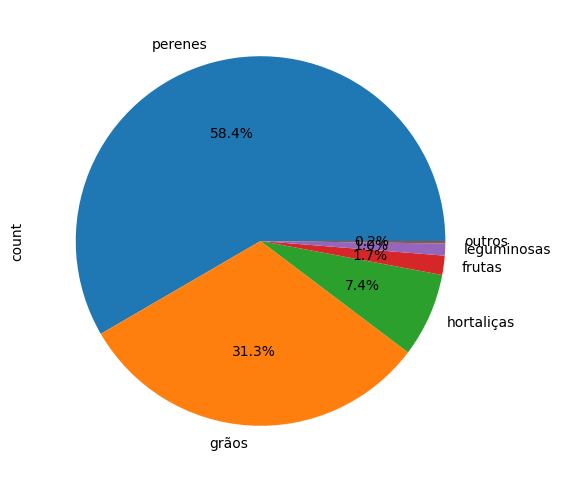

In [31]:
# gráfico de pizza - tipos de cultura no estado
plt.figure(figsize=(10,6))
df['tipo_cultura'].value_counts().plot(kind='pie', autopct='%1.1f%%');

**5 - Interpretação do gráfico de pizza com a porcentagem das apólices de cada tipo de cultura:**

É a mesma informação do gráfico anterior, porém, considerando a porcentagem das apólices dentro do total. As culturas perenes representam 58% das apólices, os grãos representam mais de 30%. As outras juntas representam cerca de 10% das apólices.

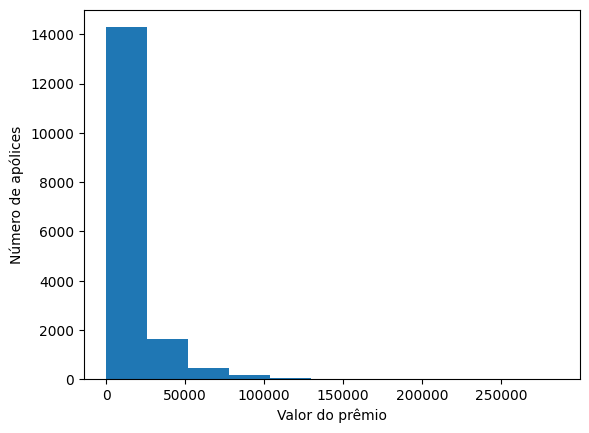

In [32]:
# histograma dos valores de prêmio
# é possível alterar o número de colunas (bins)
ax = df['premio'].plot(kind='hist', bins=11)
ax.set_ylabel('Número de apólices')
ax.set_xlabel('Valor do prêmio');

**6 - Interpretação do histograma dos valores de prêmio**

No histograma dos valores de prêmio é possível notar que mais de 14.000 apólices têm prêmios de até R\$25.000,00. Menos de 2.000 apólices apresentam prêmio entre 25 e 50 mil reais. Há poucas apólices com valores acima de 50 mil reais.

Poderíamos pedir para ver quais são as de valores altos de prêmio:

In [33]:
df[df['premio'] > 100000]

,apolice,mun,nome_mun,uf,seguradora,tipo,cultura,tipo_cultura,area,animal,duracao,prod_est,prod_seg,nivel_cob,total_seg,premio,taxa,subvencao,indenizacao,evento,sinistro,sinistralidade
15,10001010026777,3134202,Ituiutaba,MG,Newe Seguros S.A,custeio,Milho 2ª safra,grãos,677.50,0,180,5142.60,3600.00,0.70,2642250.00,216136.05,0.08,47982.20,521594.22,seca,1,2.41
110,1101.75.35538,3143203,Monte Santo de Minas,MG,Porto Seguro Companhia de Seguros Gerais,produtividade,Tomate,hortaliças,17.85,0,365,78431.37,70588.23,0.90,980000.00,116698.00,0.12,46679.20,0.00,nenhum,0,0.00
167,1101.75.35589,3143203,Monte Santo de Minas,MG,Porto Seguro Companhia de Seguros Gerais,produtividade,Tomate,hortaliças,18.11,0,365,78431.37,70588.23,0.90,994000.00,118366.00,0.12,47346.40,184585.80,granizo,1,1.56
216,1101.75.35627,3143203,Monte Santo de Minas,MG,Porto Seguro Companhia de Seguros Gerais,produtividade,Tomate,hortaliças,18.11,0,365,78431.37,70588.23,0.90,994000.00,118366.00,0.12,47346.40,127729.00,granizo,1,1.08
250,1101.75.35635,3117108,Conceição da Aparecida,MG,Porto Seguro Companhia de Seguros Gerais,produtividade,Tomate,hortaliças,15.30,0,365,78431.37,70588.23,0.90,840000.00,100027.00,0.12,40010.80,0.00,nenhum,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16537,169639,3170404,Unaí,MG,BRASILSEG COMPANHIA DE SEGUROS,custeio,Milho 2ª safra,grãos,272.23,0,365,6000.00,3900.00,0.65,1754992.23,141896.84,0.08,17331.79,0.00,nenhum,0,0.00
16539,180142,3119302,Coromandel,MG,BRASILSEG COMPANHIA DE SEGUROS,custeio,Milho 2ª safra,grãos,296.00,0,365,6000.00,3900.00,0.65,1209426.42,166325.05,0.14,31186.64,0.00,nenhum,0,0.00
16543,188730,3119302,Coromandel,MG,BRASILSEG COMPANHIA DE SEGUROS,custeio,Milho 2ª safra,grãos,393.00,0,365,6000.00,3900.00,0.65,1680329.66,233419.70,0.14,31980.00,0.00,seca,1,0.00
16587,187696,3145000,Nova Ponte,MG,BRASILSEG COMPANHIA DE SEGUROS,custeio,Milho 2ª safra,grãos,286.00,0,365,6900.00,4485.00,0.65,1487200.03,104104.00,0.07,18296.99,0.00,nenhum,0,0.00


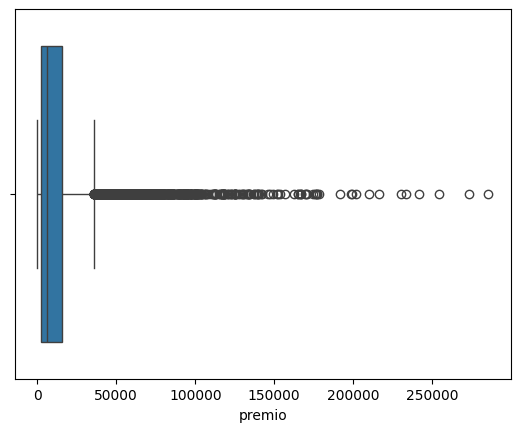

In [34]:
# boxplot - premio
sns.boxplot(x=df['premio']);

**7 - Interpretação do boxplot dos valores de prêmio**

No boxplot da variável prêmio é possível ver a distribuição dela. A caixinha representa: primeiro, segundo e terceiro quartis que são, respectivamente, 2097,99; 6.294,83 e 15.646,11 (tudo em reais). Os pontos à direita são os outliers, ou seja, valores discrepantes (não há outliers à esquerda porque não existem valores de prêmio negativos).

In [35]:
# a informação presente no boxplot
df['premio'].describe()

,premio
count,16605.00
mean,12855.68
std,18932.07
min,55.34
25%,2091.00
50%,6288.05
75%,15624.68
max,285548.96


# Relação entre as variáveis

In [36]:
# correlação entre as variáveis numéricas
df.loc[:, ['area', 'animal', 'duracao', 'prod_est', 'prod_seg',
       'nivel_cob', 'total_seg', 'premio', 'taxa', 'subvencao', 'indenizacao',
       'evento', 'sinistro', 'sinistralidade']].corr(numeric_only=True)

,area,animal,duracao,prod_est,prod_seg,nivel_cob,total_seg,premio,taxa,subvencao,indenizacao,sinistro,sinistralidade
area,1.00,-0.00,0.00,-0.00,-0.00,0.01,0.02,0.02,-0.00,0.02,0.01,0.02,0.01
animal,-0.00,1.00,-0.00,-0.02,-0.02,-0.08,0.06,0.01,-0.06,0.03,-0.01,-0.02,-0.01
duracao,0.00,-0.00,1.00,-0.11,-0.13,-0.13,-0.00,-0.08,-0.30,-0.03,-0.03,-0.15,-0.03
prod_est,-0.00,-0.02,-0.11,1.00,0.99,0.34,-0.04,0.01,0.27,0.04,-0.01,0.03,-0.00
prod_seg,-0.00,-0.02,-0.13,0.99,1.00,0.33,-0.04,0.01,0.27,0.03,-0.01,0.02,-0.00
nivel_cob,0.01,-0.08,-0.13,0.34,0.33,1.00,0.05,0.31,0.50,0.26,0.02,0.03,-0.01
total_seg,0.02,0.06,-0.00,-0.04,-0.04,0.05,1.00,0.43,-0.08,0.44,0.12,0.01,0.01
premio,0.02,0.01,-0.08,0.01,0.01,0.31,0.43,1.00,0.22,0.89,0.21,0.05,0.00
taxa,-0.00,-0.06,-0.30,0.27,0.27,0.50,-0.08,0.22,1.00,0.21,0.04,0.26,0.07
subvencao,0.02,0.03,-0.03,0.04,0.03,0.26,0.44,0.89,0.21,1.00,0.29,0.11,0.05


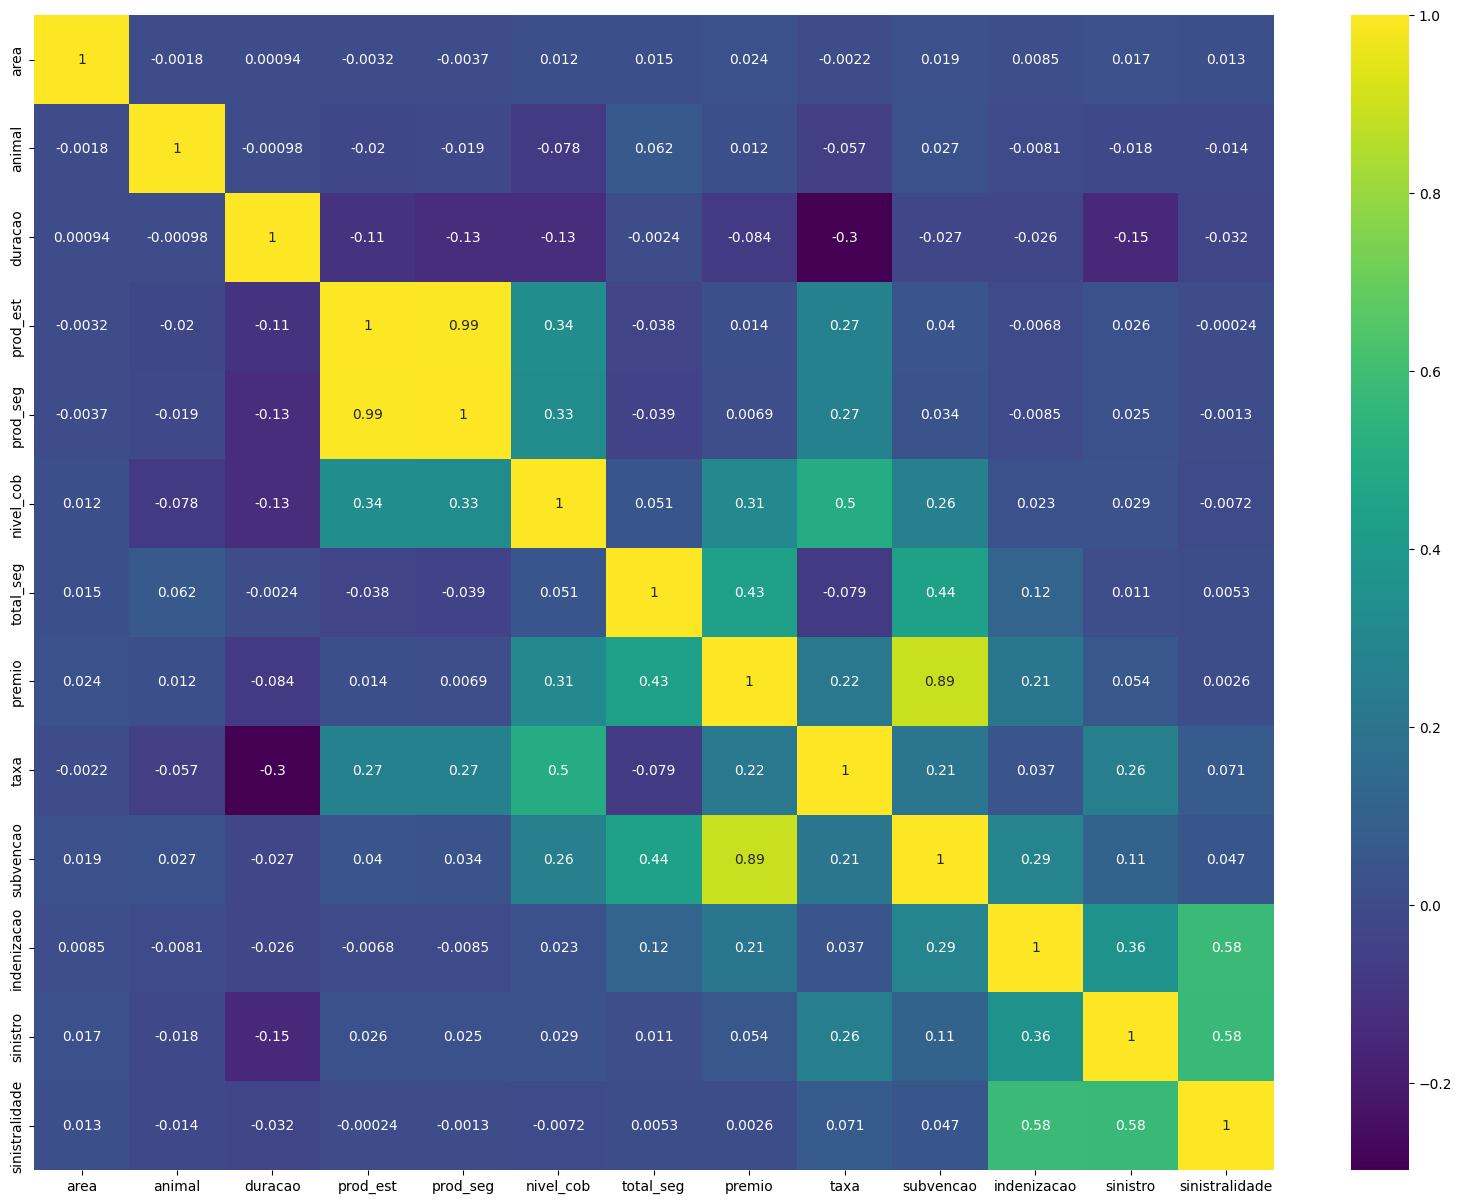

In [37]:
# heatmap - correlações
plt.figure(figsize=(20,15))
sns.heatmap(df.loc[:, ['area', 'animal', 'duracao', 'prod_est', 'prod_seg',
       'nivel_cob', 'total_seg', 'premio', 'taxa', 'subvencao', 'indenizacao',
       'evento', 'sinistro', 'sinistralidade']].corr(numeric_only=True),cmap="viridis",annot=True);

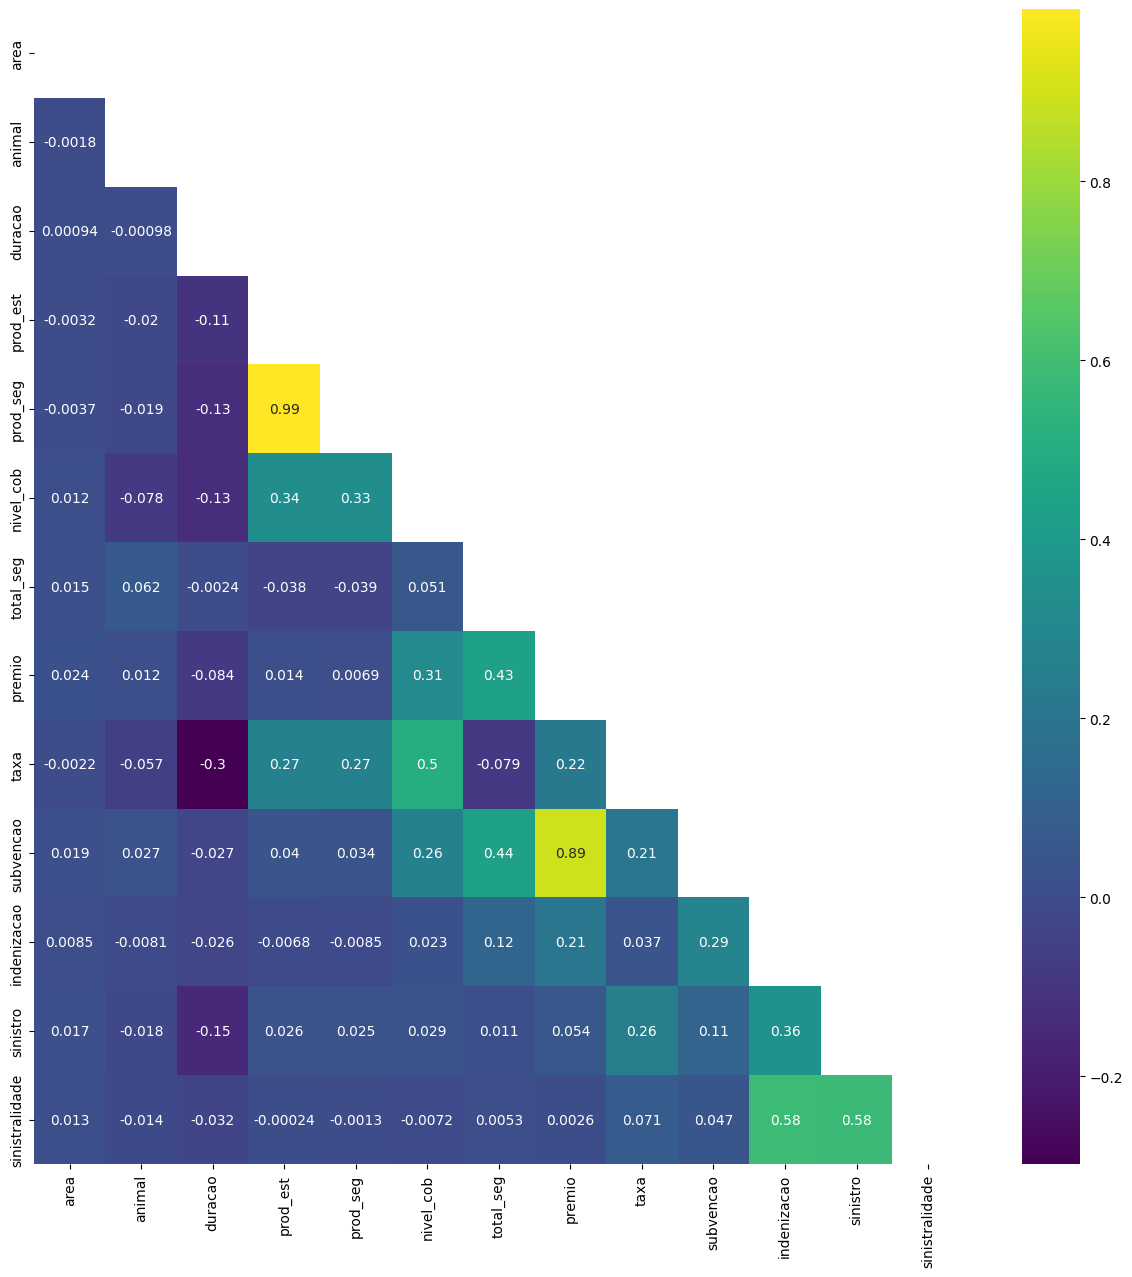

In [38]:
fig, ax = plt.subplots(figsize=(15, 15))         # tamanho da figura
r = df.loc[:, ['area', 'animal', 'duracao', 'prod_est', 'prod_seg',
       'nivel_cob', 'total_seg', 'premio', 'taxa', 'subvencao', 'indenizacao',
       'evento', 'sinistro', 'sinistralidade']].corr(numeric_only=True)
mask = np.zeros_like(r)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(r, cmap='viridis', annot=True, mask=mask, ax=ax); # se tirar o 'mask' aparece a parte superior da matriz

**8 - Interpretação das correlações entre as variáveis:**

As maiores correlações positivas são:
- 0,99: prod_seg e prod_est (correlação positiva quase perfeita)
- 0,89: subvencao e premio (correlação positiva alta, já que o valor de subvenção é concedido como uma porcentagem do valor do prêmio)
- 0,68: sinistralidade e sinistro (correlação positiva moderada e faz sentido porque a variável sinistro vale 1 para as apólices que tiveram sinistro)
- 0,65: sinistralidade e indenizacao (também faz sentido porque a sinistralidade é calculada pela razão indenização/prêmio, ou seja, ela é diretamente ligada à indenização)

As maiores correlações negativas são fracas:
- -0,3: taxa e duração (por ser baixa a correlação, nem vale a pena interpretar)

Lembrar que correlação não implica causalidade.

Diagramas de dispersão: vamos fazer alguns diagramas de dispersão para observar como os pares de variáveis se comportam.

Pares de variáveis que tiveram correlação alta:

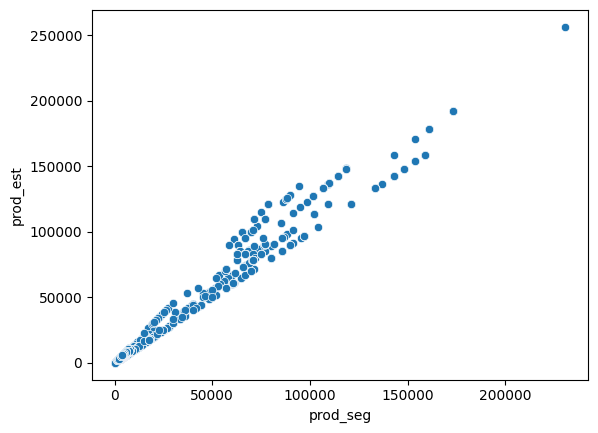

In [39]:
# diagrama de dispersão entre prod_seg e prod_est
ax = sns.scatterplot(x='prod_seg',
                y='prod_est',
                data=df)
ax.set_title('')
plt.show()

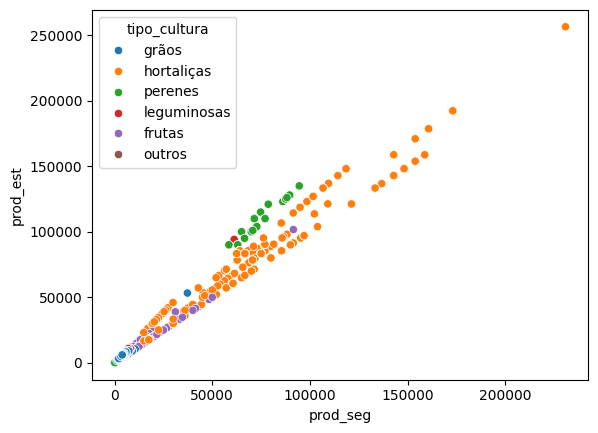

In [40]:
# diagrama de dispersão entre prod_seg e prod_est
# tipo_cultura nas cores
ax = sns.scatterplot(x='prod_seg',
                y='prod_est',
                hue='tipo_cultura',
                data=df)
ax.set_title('')
plt.show()

In [41]:
df[df['prod_est'] == df['prod_est'].max()]

,apolice,mun,nome_mun,uf,seguradora,tipo,cultura,tipo_cultura,area,animal,duracao,prod_est,prod_seg,nivel_cob,total_seg,premio,taxa,subvencao,indenizacao,evento,sinistro,sinistralidade
8498,1101.75.37077,3162005,São Gonçalo do Sapucaí,MG,Porto Seguro Companhia de Seguros Gerais,produtividade,Pimentão,hortaliças,1.95,0,365,256410.26,230769.23,0.90,95000.00,6633.00,0.07,2653.20,0.00,nenhum,0,0.00


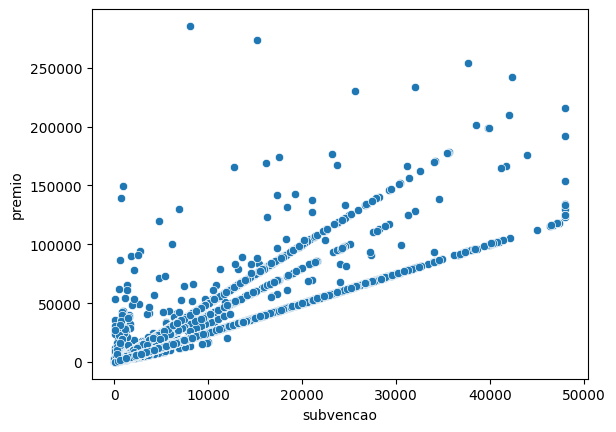

In [42]:
# diagrama de dispersão entre subvenção e prêmio
ax = sns.scatterplot(x='subvencao',
                y='premio',
                data=df)
ax.set_title('')
plt.show()

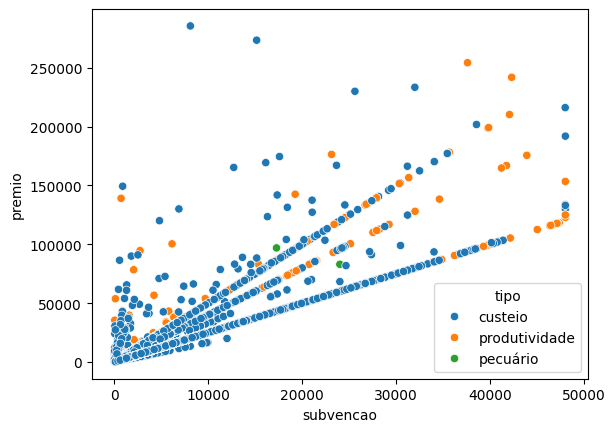

In [43]:
# diagrama de dispersão entre subvenção e prêmio
# mais tipo de seguro nas cores
ax = sns.scatterplot(x='subvencao',
                y='premio',
                hue='tipo',
                data=df)
ax.set_title('')
plt.show()

Pares de variáveis que tiveram correlação baixa:

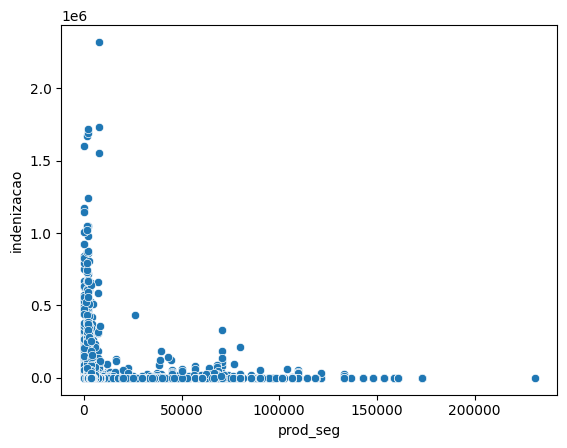

In [44]:
ax = sns.scatterplot(x='prod_seg',
                y='indenizacao',
                data=df)
ax.set_title('')
plt.show()